# COVIDdata

Yet another python package for accessing COVID-19 data. Sorry. I have opinions and I don't like all the others.

This package provides methods for fetching various COVID-19 related data sources. Results are provided as [xarray](http://xarray.pydata.org/) datasets, with consistent variable naming and attribution data included.

## Installation

I'm not going to clutter PyPI up with yet another COVID package. Just do `pip install git+https://github.com/russs/coviddata#egg=coviddata`.


## Worldwide Data

My preferred wordwide data source is [Our World in Data](https://ourworldindata.org/coronavirus-source-data) which sources their data from the ECDC. The `cases_owid` function downloads this data and returns a Dataset.

In [1]:
import coviddata.world
world_cases = coviddata.world.cases_owid()
world_cases

<xarray.Dataset>
Dimensions:   (date: 104, location: 207)
Coordinates:
  * location  (location) object 'Afghanistan' 'Albania' ... 'Zambia' 'Zimbabwe'
  * date      (date) datetime64[ns] 2019-12-31 2020-01-01 ... 2020-04-12
Data variables:
    cases     (location, date) float64 0.0 0.0 0.0 0.0 ... 11.0 11.0 11.0 14.0
    deaths    (location, date) float64 0.0 0.0 0.0 0.0 0.0 ... 2.0 3.0 3.0 3.0
Attributes:
    date:        2020-04-12
    source_url:  https://cowid.netlify.com/data/ecdc/full_data.csv
    source:      ECDC (Our World in Data)

We can filter this data by country, and convert it to a [pandas](https://pandas.pydata.org/) dataframe, giving us easy access to pandas' plotting functions.

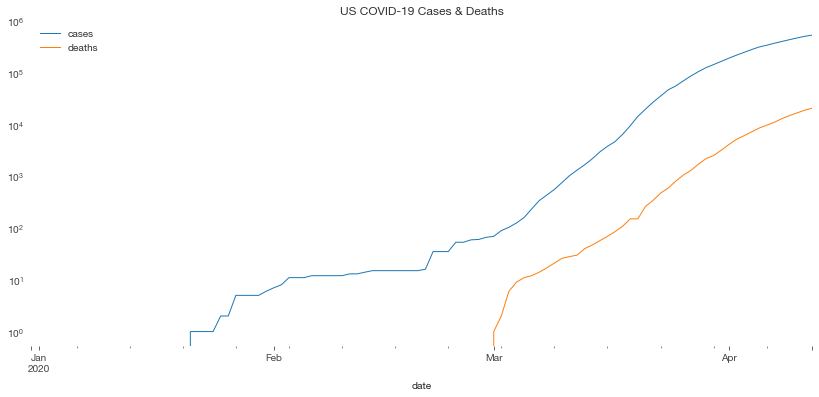

In [10]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 6]

(world_cases.sel(location="United States")
     .to_dataframe()
     .plot(logy=True, title="US COVID-19 Cases & Deaths"))

## Country-specific Data

Some country-specific data sources are more reliable or complete.

UK data can be fetched from [Public Health England](https://www.gov.uk/government/publications/covid-19-track-coronavirus-cases), and US data from the [Covid Tracking Project](https://covidtracking.com/):

In [3]:
import coviddata.uk
uk_cases = coviddata.uk.cases_phe()
uk_cases

<xarray.Dataset>
Dimensions:   (date: 73, location: 1)
Coordinates:
  * location  (location) <U14 'United Kingdom'
  * date      (date) datetime64[ns] 2020-01-31 2020-02-01 ... 2020-04-12
Data variables:
    cases     (location, date) int64 2 2 2 2 2 ... 60733 65077 70272 74895 79345
    deaths    (location, date) float64 nan nan nan ... 9.875e+03 1.061e+04
Attributes:
    date:        2020-04-12
    source:      Public Health England
    source_url:  https://www.arcgis.com/sharing/rest/content/items/e5fd11150d...

In [4]:
import coviddata.us
us_cases = coviddata.us.cases_covidtracking()
us_cases

<xarray.Dataset>
Dimensions:   (date: 44, location: 1)
Coordinates:
  * location  (location) <U13 'United States'
  * date      (date) datetime64[ns] 2020-02-28 2020-02-29 ... 2020-04-11
Data variables:
    cases     (location, date) int64 9 18 31 35 ... 424289 458635 493252 522843
    deaths    (location, date) int64 4 5 8 11 14 ... 14547 16424 18488 20355
    tests     (location, date) int64 9 18 31 35 ... 2375355 2529282 2665666
Attributes:
    date:        2020-04-11
    source:      COVID Tracking Project
    source_url:  http://covidtracking.com/api/us/daily.csv

## Merging

There's also a function to allow you quickly to combine these sources together:

In [5]:
from coviddata import merge

combined_cases = merge(world_cases, uk_cases, us_cases)
combined_cases

<xarray.Dataset>
Dimensions:   (date: 104, location: 207)
Coordinates:
  * date      (date) datetime64[ns] 2019-12-31 2020-01-01 ... 2020-04-12
  * location  (location) object 'Afghanistan' 'Albania' ... 'Zambia' 'Zimbabwe'
Data variables:
    cases     (location, date) float64 0.0 0.0 0.0 0.0 ... 11.0 11.0 11.0 14.0
    deaths    (location, date) float64 0.0 0.0 0.0 0.0 0.0 ... 2.0 3.0 3.0 3.0
    tests     (location, date) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    source:      ['ECDC (Our World in Data)', 'Public Health England', 'COVID...
    source_url:  ['https://cowid.netlify.com/data/ecdc/full_data.csv', 'https...
    date:        [datetime.date(2020, 4, 12), datetime.date(2020, 4, 12), dat...

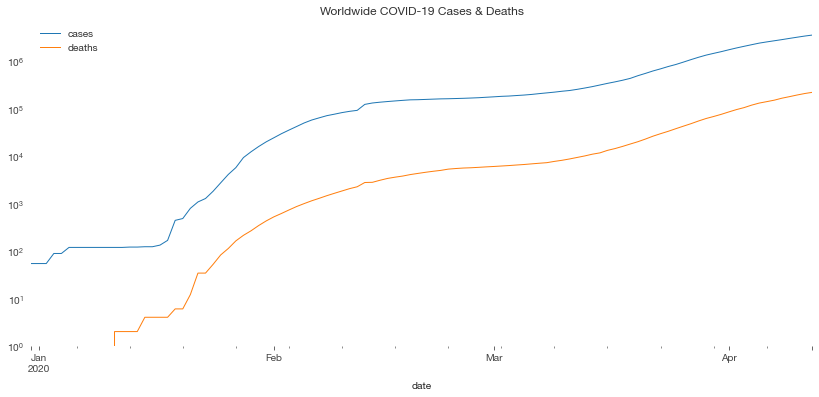

In [11]:
(combined_cases.sum(dim='location')
     .to_dataframe()
     .drop(columns=['tests'])
     .plot(logy=True, title="Worldwide COVID-19 Cases & Deaths"))

## UK NHS Triage Data

The NHS [publishes statistics](https://digital.nhs.uk/data-and-information/publications/statistical/mi-potential-covid-19-symptoms-reported-through-nhs-pathways-and-111-online) on the number of COVID-19 triage decisions made over 999, 111, and 111 Online.

These functions are dependent on screen-scraping the NHS website and may be more unreliable.

In [7]:
nhs_pathways = coviddata.uk.triage_nhs_pathways()
nhs_pathways

<xarray.Dataset>
Dimensions:    (age_band: 3, ccg: 229, date: 22, sex: 3, site_type: 2)
Coordinates:
  * date       (date) datetime64[ns] 2020-03-18 2020-03-19 ... 2020-04-08
  * age_band   (age_band) object '0-18 years' '19-69 years' '70-120 years'
  * ccg        (ccg) object 'E38000001' 'E38000002' ... 'ZC030' 'ZC040'
  * site_type  (site_type) int64 111 999
  * sex        (sex) object 'Female' 'Male' 'Unknown'
    ccg_name   (date, age_band, ccg, site_type, sex) object 'NHS Airedale, Wharfedale and Craven CCG' ... nan
Data variables:
    count      (date, age_band, ccg, site_type, sex) float64 8.0 6.0 ... nan nan
Attributes:
    date:        2020-04-08
    source:      NHS England
    source_url:  https://files.digital.nhs.uk/41/581BEE/NHS%20Pathways%20Covi...

In [8]:
nhs_online = coviddata.uk.triage_nhs_online()
nhs_online

<xarray.Dataset>
Dimensions:   (age_band: 3, ccg: 209, date: 22, sex: 2)
Coordinates:
  * date      (date) datetime64[ns] 2020-03-18 2020-03-19 ... 2020-04-08
  * age_band  (age_band) object '0-18 years' '19-69 years' '70+ years'
  * ccg       (ccg) object 'E38000001' 'E38000002' ... 'E38000247' 'E38000248'
  * sex       (sex) object 'Female' 'Male'
    ccg_name  (date, age_band, ccg, sex) object 'NHS Airedale, Wharfedale and Craven CCG' ... 'NHS West Sussex CCG'
Data variables:
    count     (date, age_band, ccg, sex) float64 17.0 16.0 27.0 ... 6.0 7.0 12.0
Attributes:
    date:        2020-04-08
    source:      NHS England
    source_url:  https://files.digital.nhs.uk/BB/32CB5C/111%20Online%20Covid-...

(0.0, 153673.3)

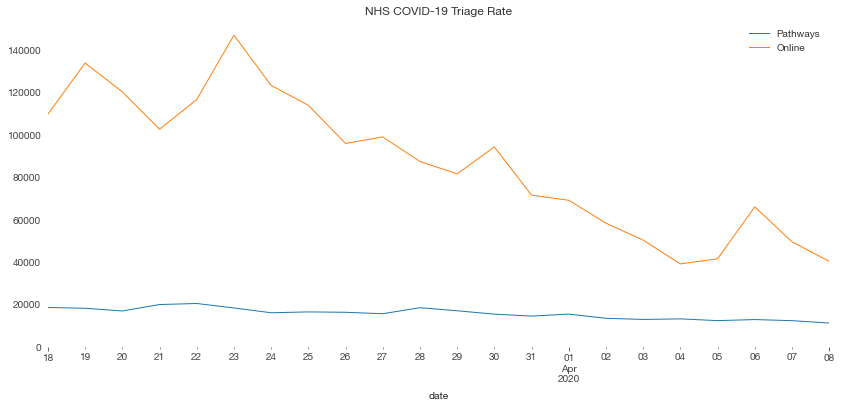

In [16]:
import matplotlib.pyplot as plt
ax = plt.axes()
(nhs_pathways.sum(['age_band', 'ccg', 'sex', 'site_type'])
     .to_dataframe()
     .plot(ax=ax, label='Pathways', y='count'))

(nhs_online.sum(['age_band', 'ccg', 'sex'])
     .to_dataframe()
     .plot(ax=ax, label='Online', y='count'))

plt.title("NHS COVID-19 Triage Rate")
plt.ylim(0)